# Energy sums and resolution

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf, erfc, gamma
import numpy as np
import pandas as pd
import uproot

In [2]:
def gaussian(x, A, sigma, mu):
    return A/(sigma * np.sqrt(2 * np.pi))*np.exp( - (x - mu)**2 / (2 * sigma**2) )

def repeatedGausFit(histogram, energy, rangeInSigmaLeft = 1., rangeInSigmaRight = 2.5):
    Sampl = 2.198e-01
    Noise = 8.210e-03
    Linear = 3e-6
    h_med = histogram.median()

    #Check whether we're working with raw energies or visible energy in GeV.
    #Binning and std_dev of the initial distribution are set accrodingly.
    
    #I did not understand why energy is multiplied by 100 and why we have a division in 1000
    
    if h_med > 1000:
        h_std = np.sqrt(Noise*Noise + Sampl*Sampl*energy + Linear*Linear*(energy**2))*100.0
        binning = np.linspace(np.median(histogram)*0.8, np.median(histogram)*1.2, 100)
    if h_med < 1000:
        h_std = np.sqrt(Noise*Noise + Sampl*Sampl*energy + Linear*Linear*(energy**2))
        binning = np.linspace(np.median(histogram)*0.8, np.median(histogram)*1.2, 80)

    n, bins = np.histogram(histogram, density = True, bins=binning)

    bins = 0.5*(bins[1:]+bins[:-1])
    ymaximum = n.max()
    s_fit = (bins > h_med - rangeInSigmaLeft*h_std) & (bins < (h_med + rangeInSigmaRight*h_std))
    popt, pcov = curve_fit(gaussian, bins[s_fit], n[s_fit], p0=[ymaximum, h_std, h_med])

    for i in range(9):
        mu_tmp = popt[2]
        std_tmp = popt[1]
        ymaximum_tmp = popt[0]
        s_fit = (bins > mu_tmp- rangeInSigmaLeft*std_tmp) & (bins < mu_tmp + rangeInSigmaRight*std_tmp)

        popt, pcov = curve_fit(gaussian, bins[s_fit], n[s_fit], p0=[ymaximum_tmp, std_tmp , mu_tmp])

    E_reco = popt[2]
    sigma = popt[1]
    err = np.sqrt(np.diag(pcov))
    E_err = err[2]
    sigma_err = err[1]

    return E_reco, E_err, sigma, sigma_err

In [3]:
#Pandas object creation function with the data already ready to work
def PandasCreator(fname, branches, key, nentries):
    
    # Opening TTree with uproot
    # and converting into pandas df
    ttree = uproot.open(fname)[key]
    df = ttree.pandas.df(branches, entrystop=nentries)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']
        
    # Noise cut at 0.5 MIPs
    df = df[ df['rechit_energy'] > 0.5 ]
        
    #selecting only CE-E layers and removing the chip 0 of layer 1 because it is known to be broken
    df_red = df[ (df['rechit_layer'] != 1) | (df['rechit_chip'] != 0) ]
    df_red = df_red[ df_red['rechit_layer'] < 29 ]
        
    return df_red

In [4]:
#Getting the total energy sum per event
def doEsums(pandas):
    
    esum_red = pandas.groupby('event').rechit_energy.sum()
        
    return esum_red

In [5]:
def line(x, m, q):
    return m*x + q

In [6]:
#Getting the total energy per event and the nominal energy from a pandas file
def plotting(energy, resol, popt, pcov ):
    
    t = plt.plot(energy ,resol, 'o')
    plt.plot(np.linspace(18,310,300), resFin(np.linspace(18,310,300), *popt), '-')
    plt.xlabel('Energy [GeV]')
    plt.ylabel('Resolution')
        
    ## Print the value of the fit parameters.
    perr = np.sqrt(np.diag(pcov))
    print('Fit parameters: C = %.4f, S = %.4f, N = %.6f' %(popt[0], popt[1], popt[2]))
    print(r'Fit uncertainties: $\sigma_{C}$ = %.4f, $\sigma_{S}$ = %.4f, $\sigma_{N}$ = %.6f' %(perr[0], perr[1], perr[2]))
        
    return t

In [7]:
def resolution(x, stoc, const):
    '''
        Nice article about calorimetry: 
        http://lappweb.in2p3.fr/~chefdevi/Detector_reports/Calorimetry/Fabjan.pdf
        See page 10 for explanation about the energy resolution terms.
        Energy resolution with stochastic and constant terms.
        The noise term is not considered as TB studies show
        we are well confident with having noise ~ 0.
    '''
    return np.sqrt(stoc**2/x + const**2)

In [8]:
energies = np.array([20, 30, 50, 80, 100, 120, 150, 200, 250, 300])
true_E   = np.array([20, 30, 49.99, 79.93, 99.83, 119.65, 149.14, 197.32, 243.61, 287.18])
runs = {
    20:  455,
    30:  596,
    50:  458,
    80:  469,
    100: 490,
    120: 620,
    150: 494,
    200: 664,
    250: 653,
    300: 435
}

In [9]:
data_path = '/data_CMS/cms/bonanomi/electrons/'
mc_path   = '/data_CMS/cms/bonanomi/mc_electrons/'
key='rechitntupler/hits'
branches = [u'rechit_chip', 'rechit_module', 'rechit_channel', u'rechit_energy', 'rechit_layer', 'beamEnergy']

In [10]:
E_reconMC = []
E_recon_errMC = []
sigmasMC = []
sigmas_errMC = []

#running for all files
for energy in energies:       
    fname = mc_path + 'ntuple_sim_config22_pdgID11_beamMomentum%i_listFTFP_BERT_EMN.root'%energy

    #Building the Pandas file
    df_red = PandasCreator(fname, branches, key, 5000)

    #Getting the total energy per event and the nominal energy
    esum = doEsums(df_red)

    #Extracting the reconstructed energy of the beam and its dispersion
    E_reco, E_err, sigma, sigma_err = repeatedGausFit(esum, energy)

    #Saving reconstructed data
    E_reconMC.append(E_reco)
    E_recon_errMC.append(E_err)
    sigmasMC.append(sigma)
    sigmas_errMC.append(sigma_err)

In [11]:
E_recon = []
E_recon_err = []
sigmas = []
sigmas_err = []
for energy in energies:
    run = runs[energy]
    fname = data_path + 'ntuple_%i.root' %run

    #Building the Pandas file
    df_red = PandasCreator(fname, branches, key, 5000)

    #Getting the total energy per event and the nominal energy
    esum = doEsums(df_red)

    #Extracting the reconstructed energy of the beam and its dispersion
    E_reco, E_err, sigma, sigma_err = repeatedGausFit(esum, energy)

    #Saving reconstructed data
    E_recon.append(E_reco)
    E_recon_err.append(E_err)
    sigmas.append(sigma)
    sigmas_err.append(sigma_err)

In [12]:
popt_dt, pcov_dt = curve_fit(line, true_E, E_recon)
popt_mc, pcov_mc = curve_fit(line, true_E, E_reconMC)

In [13]:
draw_e = np.linspace(20, 310, 100)

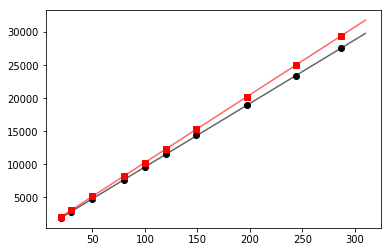

In [14]:
plt.plot(true_E, E_recon, 'ko', label = 'Data')
plt.plot(draw_e, line(draw_e, *popt_dt), 'k-', alpha = 0.6, label = 'Data')
plt.plot(true_E, E_reconMC, 'rs', label = 'MC')
plt.plot(draw_e, line(draw_e, *popt_mc), 'r-', alpha = 0.6, label = 'Data')

## Bonus: the residuals

(-0.008, 0.008)

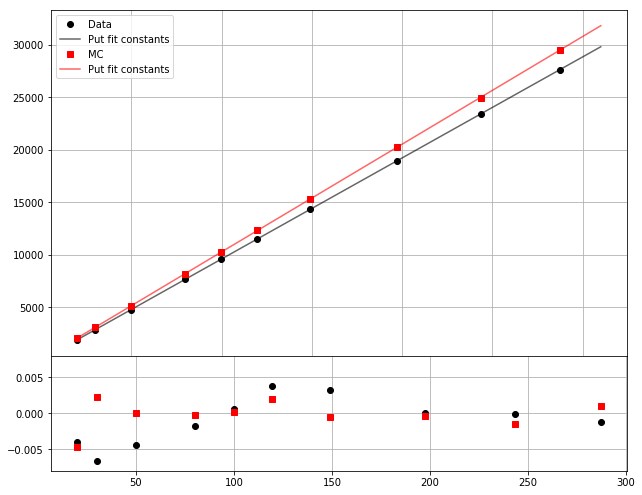

In [15]:
fig = plt.figure(figsize=(10,8))
frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(true_E, E_recon, 'ko', label = 'Data')
plt.plot(draw_e, line(draw_e, *popt_dt), 'k-', alpha = 0.6, label = 'Put fit constants')
plt.plot(true_E, E_reconMC, 'rs', label = 'MC')
plt.plot(draw_e, line(draw_e, *popt_mc), 'r-', alpha = 0.6, label = 'Put fit constants')
plt.grid(b = None)
plt.legend()

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
frame2=fig.add_axes((.1,.1,.8,.2)) 
residuals_data = (E_recon - line(true_E, *popt_dt))/line(true_E, *popt_dt)
plt.plot(true_E, residuals_data,'ko', label = 'Data')
residuals_MC = (E_reconMC - line(true_E, *popt_mc))/line(true_E, *popt_mc)
plt.plot(true_E, residuals_MC,'rs', label = 'MC')
plt.grid(b = None)
plt.ylim(-0.008, 0.008)

In [16]:
resol = np.array(sigmas)/np.array(E_recon)
resolMC = np.array(sigmasMC)/np.array(E_reconMC)

In [17]:
popt_res_dt, pcov_res_dt = curve_fit(resolution, true_E, resol)
popt_res_mc, pcov_res_mc = curve_fit(resolution, true_E, resolMC)

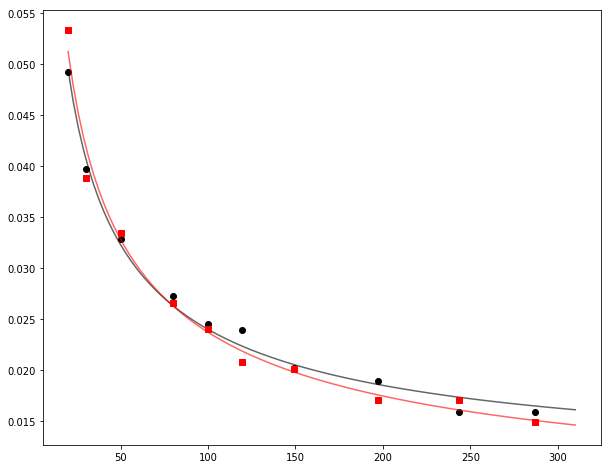

In [18]:
plt.figure(figsize = (10,8))
plt.plot(true_E, resol, 'ko', label = 'Data')
plt.plot(draw_e, resolution(draw_e, *popt_res_dt), 'k-', alpha = 0.6, label = 'Data')
plt.plot(true_E, resolMC, 'rs', label = 'MC')
plt.plot(draw_e, resolution(draw_e, *popt_res_mc), 'r-', alpha = 0.6, label = 'Data')